# Seed Counting (DIPA) — Workflow 1 & 2 POC → Full Run → Metrics → ML

This notebook is organised so you can run cells independently.
- **POC runner** only evaluates: 5, 30, 70, 90, 120 (by filename).
- **Full dataset runner** is in a separate cell and is OFF by default.
- **ML workflow** is in a separate cell and is OFF by default.
- Debug cells show intermediate images for screenshots.


In [14]:
# =========================
# 0) Imports + User Settings
# =========================
import os, re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CHANGE THIS: folder containing images named like 5.jpg, 30.jpg, ...
DATASET_DIR = r"seeds"

# POC images (by filename ground truth)
TARGETS = [60]

# Speed-up: downscale huge images (keeps visual quality for counting)
MAX_DIM = 1100

# Safety switches (leave False until you're ready)
RUN_FULL_DATASET = True
RUN_ML_WORKFLOW = True

plt.rcParams["figure.dpi"] = 120


In [15]:
# =========================
# 1) Display + I/O helpers
# =========================
def show_row(images, titles, suptitle="", figsize=(26, 4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (img, t) in enumerate(zip(images, titles), 1):
        ax = plt.subplot(1, n, i)
        if img is None:
            ax.set_title(t); ax.axis("off"); continue
        if img.ndim == 2:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(t, fontsize=10)
        ax.axis("off")
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

def read_bgr_fast(path, max_dim=1100):
    """Downscale only if needed (fast) using INTER_AREA."""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    h, w = img.shape[:2]
    m = max(h, w)
    if m > max_dim:
        s = max_dim / float(m)
        img = cv2.resize(img, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
    return img

def gt_from_filename(path):
    base = os.path.splitext(os.path.basename(path))[0]
    if not re.fullmatch(r"\d+", base):
        raise ValueError(f"Filename must be digits only: {path}")
    return int(base)


In [16]:
# =========================
# 2) Binary mask utilities
# =========================
def keep_by_area(bw, min_area=50, max_area=10_000_000):
    """Keep connected components with area in [min_area, max_area]."""
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
    out = np.zeros_like(bw)
    for lab in range(1, num):
        area = stats[lab, cv2.CC_STAT_AREA]
        if min_area <= area <= max_area:
            out[labels == lab] = 255
    return out

def fill_holes(bw):
    """Fill holes in a binary mask using flood fill."""
    h, w = bw.shape[:2]
    ff = bw.copy()
    mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(ff, mask, (0, 0), 255)
    inv = cv2.bitwise_not(ff)
    return cv2.bitwise_or(bw, inv)


WF1: Resize → grayscale → top-hat + black-hat + Sobel gradient → Otsu + morphology + area gate → distance transform → markers (threshold + connected components) → watershed → count regions.

WF2: Resize → grayscale → LBP texture map → light blur → Otsu + morphology + area gate → distance transform → markers → watershed → count regions.



## Workflow 1
**Goal:** classical segmentation using morphology + thresholding + watershed.
We include a **polarity-invariant** enhancement step because seeds are not always darker than background.

In [17]:
# =========================
# 3) Workflow 1 — v2 (recommended)
#    Polarity-invariant enhancement + Otsu + Morph + Area gate + Watershed
# =========================
def seedness_map(gray, k=31):
    """Polarity-invariant enhancement: top-hat + black-hat + gradient."""
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, se)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, se)

    gradx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    grady = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad = cv2.magnitude(gradx, grady)
    grad = cv2.normalize(grad, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    enh = cv2.addWeighted(tophat, 0.6, blackhat, 0.6, 0.0)
    enh = cv2.addWeighted(enh, 0.7, grad, 0.3, 0.0)
    enh = cv2.normalize(enh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return enh, tophat, blackhat, grad

def workflow1_count_v2(img_bgr, debug=False,
                       enh_k=31,
                       open_k=5,
                       min_area_floor=120,
                       dist_pct=65):
    rgb = img_bgr.copy()
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    enh, tophat, blackhat, grad = seedness_map(gray, k=enh_k)

    # Otsu on enhanced map
    _, bw = cv2.threshold(enh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphology cleanup
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k, open_k))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    bw2 = cv2.morphologyEx(bw, cv2.MORPH_OPEN, k_open, iterations=1)
    bw2 = cv2.morphologyEx(bw2, cv2.MORPH_CLOSE, k_close, iterations=2)

    # Per-image area prior (automatic, not learned from a separate image)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bw2, 8)
    areas = [stats[i, cv2.CC_STAT_AREA] for i in range(1, num)]
    if len(areas) == 0:
        return 0
    med = float(np.median(areas))
    min_area = int(max(min_area_floor, 0.25 * med))
    max_area = int(5.0 * med)

    bw3 = keep_by_area(bw2, min_area=min_area, max_area=max_area)
    bw3 = fill_holes(bw3)

    # Watershed markers from distance peaks
    dist = cv2.distanceTransform(bw3, cv2.DIST_L2, 5)
    if dist.max() <= 1e-6:
        return 0
    distn = dist / (dist.max() + 1e-6)

    vals = distn[bw3 > 0]
    thr = float(np.percentile(vals, dist_pct))
    thr = float(np.clip(thr, 0.25, 0.55))

    sure_fg = (distn >= thr).astype(np.uint8) * 255
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, k_open, iterations=1)

    sure_bg = cv2.dilate(bw3, k_close, iterations=2)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers_ws = cv2.watershed(rgb.copy(), markers)
    labels_ws = [lab for lab in np.unique(markers_ws) if lab > 1]
    count = int(len(labels_ws))

    if debug:
        overlay = rgb.copy()
        overlay[markers_ws == -1] = (255, 0, 0)
        show_row(
            [rgb, enh, tophat, blackhat, grad, bw, bw2, bw3, (distn*255).astype(np.uint8), sure_fg, overlay],
            ["Input", "Enh(seedness)", "Top-hat", "Black-hat", "Gradient",
             "Otsu", "Open+Close", f"Area gate(min={min_area})", f"DistNorm(pct={dist_pct})", "Markers", f"WS | {count}"],
            suptitle="WF1 v2 Debug",
            figsize=(30, 4)
        )

    return count


## Workflow 2
**Constraint:** use a feature method taught (SIFT/HOG/LBP). Here we implement **LBP**.
This workflow is intentionally different from WF1, and we keep its debug outputs for screenshots.

In [18]:
# =========================
# 4) Workflow 2 — LBP + Otsu + Morph + (optional) Watershed
#    Fix: LBP returns SAME SIZE as input, so watershed won't crash.
# =========================
def lbp_8u1(gray):
    """8-neighbour LBP (3x3) output SAME SIZE; border pixels = 0."""
    h, w = gray.shape
    g = gray.astype(np.int16)

    c = g[1:-1, 1:-1]
    out_inner = np.zeros_like(c, dtype=np.uint8)

    neigh = [
        g[:-2, :-2], g[:-2, 1:-1], g[:-2, 2:],
        g[1:-1, 2:],  g[2:, 2:],   g[2:, 1:-1],
        g[2:, :-2],   g[1:-1, :-2]
    ]
    for i, n in enumerate(neigh):
        out_inner |= ((n >= c).astype(np.uint8) << i)

    out = np.zeros((h, w), dtype=np.uint8)
    out[1:-1, 1:-1] = out_inner
    return out

def workflow2_count_lbp(img_bgr, debug=False,
                        blur_k=7,
                        min_area=60, max_area=60_000,
                        use_watershed=True,
                        ws_thr=0.40):
    rgb = img_bgr.copy()
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    lbp = lbp_8u1(gray)
    lbp_blur = cv2.GaussianBlur(lbp, (blur_k, blur_k), 0)

    _, bw = cv2.threshold(lbp_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    bw_m = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, k_close, iterations=1)
    bw_m = cv2.morphologyEx(bw_m, cv2.MORPH_OPEN,  k_open,  iterations=1)

    bw_a = keep_by_area(bw_m, min_area=min_area, max_area=max_area)
    bw_f = fill_holes(bw_a)

    if not use_watershed:
        n, _ = cv2.connectedComponents(bw_f)
        count = int(n - 1)
        if debug:
            show_row([rgb, lbp, lbp_blur, bw, bw_f],
                     ["Input", "LBP", f"LBP blur(k={blur_k})", "Otsu", f"Final mask | {count}"],
                     suptitle=f"WF2 (LBP, no WS) | count={count}",
                     figsize=(22, 4))
        return count

    dist = cv2.distanceTransform(bw_f, cv2.DIST_L2, 5)
    if dist.max() <= 1e-6:
        return 0
    distn = dist / (dist.max() + 1e-6)

    sure_fg = (distn >= ws_thr).astype(np.uint8) * 255
    sure_bg = cv2.dilate(bw_f, k_close, iterations=2)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers_ws = cv2.watershed(rgb.copy(), markers)
    labels_ws = [lab for lab in np.unique(markers_ws) if lab > 1]
    count = int(len(labels_ws))

    if debug:
        overlay = rgb.copy()
        overlay[markers_ws == -1] = (255, 0, 0)
        show_row(
            [rgb, lbp, lbp_blur, bw, bw_f, (distn*255).astype(np.uint8), sure_fg, overlay],
            ["Input", "LBP", f"LBP blur(k={blur_k})", "Otsu", "Mask", "DistNorm", "Markers", f"WS | {count}"],
            suptitle=f"WF2 (LBP) | count={count}",
            figsize=(26, 4)
        )

    return count


In [19]:
def find_image_by_number(dataset_dir, n):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    for ext in exts:
        p = os.path.join(dataset_dir, f"{n}{ext}")
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"No image found for {n} with extensions {exts} in {dataset_dir}")


## POC runner (ONLY 5/30/70/90/120)
This is the only runner that should execute by default.

In [20]:
# =========================
# 5) POC evaluation (runs by default)
# =========================
rows = []
for t in TARGETS:
    p = find_image_by_number(DATASET_DIR, t)
    img = read_bgr_fast(p, max_dim=MAX_DIM)
    gt = gt_from_filename(p)

    wf1 = workflow1_count_v2(img, debug=False)
    wf2 = workflow2_count_lbp(img, debug=False)

    rows.append({
        "image": os.path.basename(p),
        "gt": gt,
        "wf1_pred": int(wf1),
        "wf2_pred": int(wf2),
        "wf1_abs_err": abs(int(wf1) - gt),
        "wf2_abs_err": abs(int(wf2) - gt),
        # Count-closeness % (simple, explain in report)
        "wf1_acc_%": round(100.0 * max(0.0, 1.0 - abs(int(wf1) - gt)/gt), 2),
        "wf2_acc_%": round(100.0 * max(0.0, 1.0 - abs(int(wf2) - gt)/gt), 2),
    })

df_poc = pd.DataFrame(rows)
df_poc


,image,gt,wf1_pred,wf2_pred,wf1_abs_err,wf2_abs_err,wf1_acc_%,wf2_acc_%
0,60.jpg,60,33,33,27,27,55.0,55.0


## Debug screenshots (for report)
Run this cell on any image to capture intermediate stages.
You can also use it to show a **failed/bad** method by changing parameters.

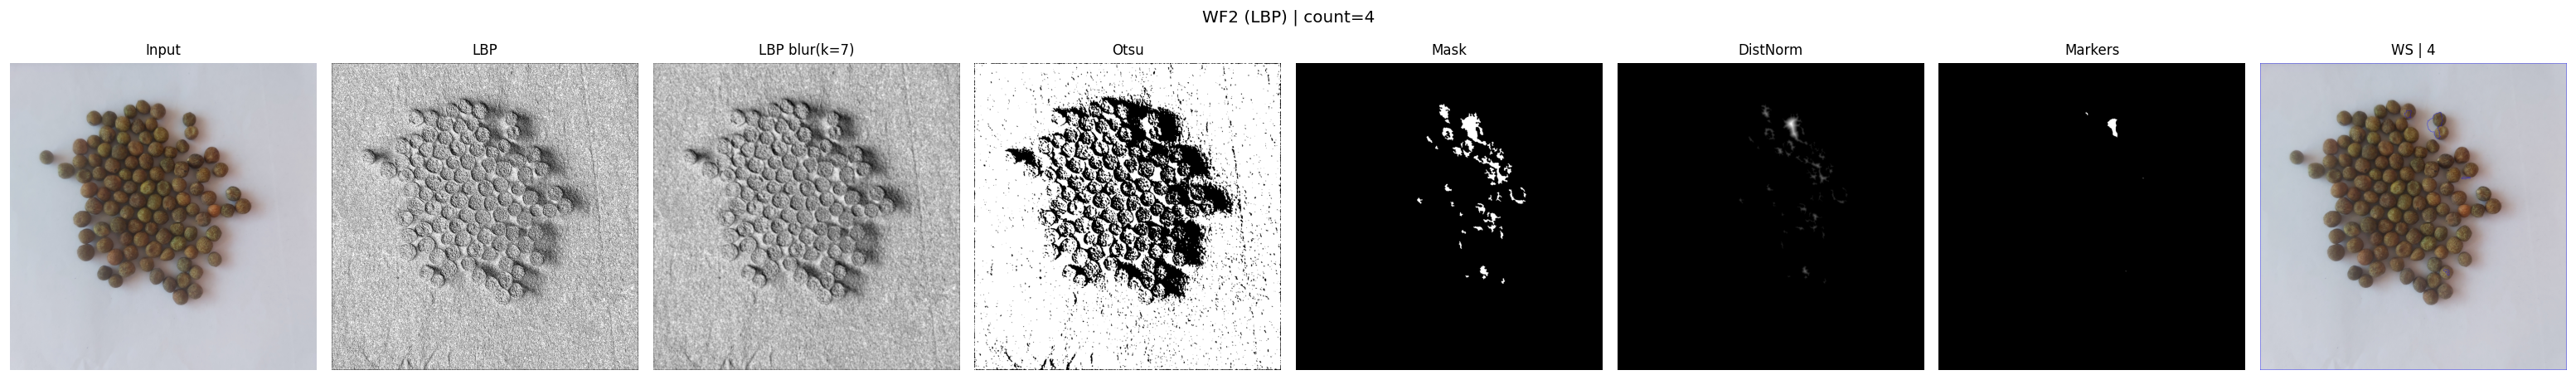

In [21]:
# =========================
# 6) Debug / screenshot cell
# =========================
DEBUG_IMAGE = 100  # change to 5, 30, 70, 90, 120 (or any filename number)

img = read_bgr_fast(os.path.join(DATASET_DIR, f"{DEBUG_IMAGE}.jpg"), max_dim=MAX_DIM)

_ = workflow1_count_v2(img, debug=True)
_ = workflow2_count_lbp(img, debug=True)

# --- Optional: show a deliberately "bad" setting for your report (example)
# _ = workflow1_count_v2(img, debug=True, dist_pct=85)  # tends to under-split in dense cases


## Metrics: Precision, Recall, PR curve, AUC (count-based proxy)
For a counting task, we use a proxy:
- TP = min(pred, gt)
- FP = max(pred - gt, 0)
- FN = max(gt - pred, 0)


In [22]:
# =========================
# 7) Precision / Recall proxy (counting)
# =========================
def pr_from_counts(gt, pred):
    tp = min(pred, gt)
    fp = max(pred - gt, 0)
    fn = max(gt - pred, 0)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return prec, rec

def pr_auc(points):
    """AUC via trapezoid after sorting by recall."""
    pts = sorted(points, key=lambda x: x[0])
    area = 0.0
    for (r1, p1), (r2, p2) in zip(pts[:-1], pts[1:]):
        area += (r2 - r1) * (p1 + p2) / 2.0
    return area, pts


In [23]:
# =========================
# 8) PR sweep + AUC on POC images (fast)
#    Sweep one parameter per workflow to show robustness.
# =========================
poc_paths = [os.path.join(DATASET_DIR, f"{t}.jpg") for t in TARGETS]

def sweep_wf1_distpct(paths, dist_pcts=range(55, 86, 5)):
    out = []
    for pct in dist_pcts:
        prs = []
        for p in paths:
            img = read_bgr_fast(p, max_dim=MAX_DIM)
            gt = gt_from_filename(p)
            pred = int(workflow1_count_v2(img, debug=False, dist_pct=pct))
            prs.append(pr_from_counts(gt, pred))
        out.append({
            "dist_pct": pct,
            "precision": float(np.mean([x[0] for x in prs])),
            "recall": float(np.mean([x[1] for x in prs])),
        })
    return pd.DataFrame(out)

df_pr_wf1 = sweep_wf1_distpct(poc_paths)

points = [(r, p) for r, p in zip(df_pr_wf1["recall"], df_pr_wf1["precision"])]
auc, pts_sorted = pr_auc(points)

print("WF1 PR-AUC (proxy):", round(auc, 4))
df_pr_wf1


WF1 PR-AUC (proxy): 0.05


,dist_pct,precision,recall
0,55,1.0,0.516667
1,60,1.0,0.550000
2,65,1.0,0.550000
3,70,1.0,0.516667
4,75,1.0,0.500000
5,80,1.0,0.516667
6,85,1.0,0.500000


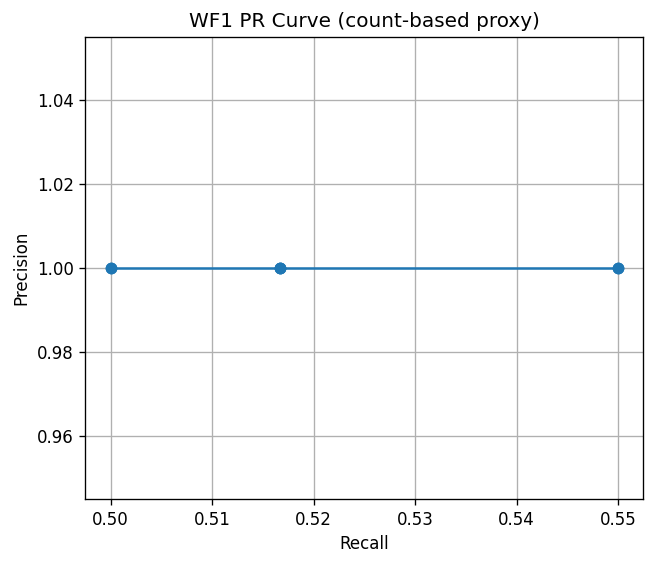

In [24]:
# Plot WF1 PR curve (for report)
plt.figure(figsize=(6,5))
plt.plot([r for r, p in pts_sorted], [p for r, p in pts_sorted], marker="o")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("WF1 PR Curve (count-based proxy)")
plt.grid(True)
plt.show()


## Full dataset runner (OFF by default)
This cell processes **all images in the folder** and computes metrics.
It does nothing unless you flip `RUN_FULL_DATASET = True` at the top.

In [25]:
# =========================
# 9) FULL DATASET RUNNER (guarded)
# =========================
if not RUN_FULL_DATASET:
    print("Full dataset runner is OFF. Set RUN_FULL_DATASET = True to run it.")
else:
    files = [f for f in os.listdir(DATASET_DIR) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff"))]
    files = [f for f in files if re.fullmatch(r"\d+\.(jpg|jpeg|png|bmp|tif|tiff)", f.lower())]
    files.sort(key=lambda f: int(os.path.splitext(f)[0]))

    rows = []
    for f in files:
        p = os.path.join(DATASET_DIR, f)
        img = read_bgr_fast(p, max_dim=MAX_DIM)
        gt = gt_from_filename(p)
        wf1 = int(workflow1_count_v2(img, debug=False))
        wf2 = int(workflow2_count_lbp(img, debug=False))
        p1, r1 = pr_from_counts(gt, wf1)
        p2, r2 = pr_from_counts(gt, wf2)

        rows.append({
            "image": f,
            "gt": gt,
            "wf1_pred": wf1,
            "wf2_pred": wf2,
            "wf1_abs_err": abs(wf1-gt),
            "wf2_abs_err": abs(wf2-gt),
            "wf1_prec": p1, "wf1_rec": r1,
            "wf2_prec": p2, "wf2_rec": r2,
            "wf1_acc_%": 100.0 * max(0.0, 1.0 - abs(wf1-gt)/gt),
            "wf2_acc_%": 100.0 * max(0.0, 1.0 - abs(wf2-gt)/gt),
        })

    df_full = pd.DataFrame(rows)
    # =========================
# 9) FULL DATASET RUNNER (guarded)
# =========================
if not RUN_FULL_DATASET:
    print("Full dataset runner is OFF. Set RUN_FULL_DATASET = True to run it.")
else:
    files = [f for f in os.listdir(DATASET_DIR) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff"))]
    files = [f for f in files if re.fullmatch(r"\d+\.(jpg|jpeg|png|bmp|tif|tiff)", f.lower())]
    files.sort(key=lambda f: int(os.path.splitext(f)[0]))

    rows = []
    for f in files:
        p = os.path.join(DATASET_DIR, f)
        img = read_bgr_fast(p, max_dim=MAX_DIM)
        gt = gt_from_filename(p)
        wf1 = int(workflow1_count_v2(img, debug=False))
        wf2 = int(workflow2_count_lbp(img, debug=False))
        p1, r1 = pr_from_counts(gt, wf1)
        p2, r2 = pr_from_counts(gt, wf2)

        rows.append({
            "image": f,
            "gt": gt,
            "wf1_pred": wf1,
            "wf2_pred": wf2,
            "wf1_abs_err": abs(wf1-gt),
            "wf2_abs_err": abs(wf2-gt),
            "wf1_prec": p1, "wf1_rec": r1,
            "wf2_prec": p2, "wf2_rec": r2,
            "wf1_acc_%": 100.0 * max(0.0, 1.0 - abs(wf1-gt)/gt),
            "wf2_acc_%": 100.0 * max(0.0, 1.0 - abs(wf2-gt)/gt),
        })

    df_full = pd.DataFrame(rows)

    # ---- NEW: save to CSV ----
    out_csv = os.path.join(DATASET_DIR, "seed_count_results_full.csv")
    df_full.to_csv(out_csv, index=False)
    print(f"\nSaved full results to: {out_csv}")

    # Preview + summary
    display(df_full.head(10))

    print("\nSummary:")
    print("WF1 mean acc %:", round(df_full["wf1_acc_%"].mean(), 2))
    print("WF2 mean acc %:", round(df_full["wf2_acc_%"].mean(), 2))



Saved full results to: seeds\seed_count_results_full.csv


,image,gt,wf1_pred,wf2_pred,wf1_abs_err,wf2_abs_err,wf1_prec,wf1_rec,wf2_prec,wf2_rec,wf1_acc_%,wf2_acc_%
0,1.jpg,1,5,46,4,45,0.2,1.000000,0.021739,1.0,0.000000,0.0
1,2.jpg,2,1,2,1,0,1.0,0.500000,1.000000,1.0,50.000000,100.0
2,3.jpg,3,2,40,1,37,1.0,0.666667,0.075000,1.0,66.666667,0.0
3,4.jpg,4,1,22,3,18,1.0,0.250000,0.181818,1.0,25.000000,0.0
4,5.jpg,5,0,67,5,62,0.0,0.000000,0.074627,1.0,0.000000,0.0
5,6.jpg,6,5,29,1,23,1.0,0.833333,0.206897,1.0,83.333333,0.0
6,7.jpg,7,6,32,1,25,1.0,0.857143,0.218750,1.0,85.714286,0.0
7,8.jpg,8,2,31,6,23,1.0,0.250000,0.258065,1.0,25.000000,0.0
8,9.jpg,9,7,30,2,21,1.0,0.777778,0.300000,1.0,77.777778,0.0
9,10.jpg,10,6,2,4,8,1.0,0.600000,1.000000,0.2,60.000000,20.0



Summary:
WF1 mean acc %: 39.82
WF2 mean acc %: 33.0


ML: Resize + filename GT → extract features (intensity stats, edge energy, mask coverage, CC stats, optional WF outputs) → train Random Forest (many trees) → round predictions → evaluate (MAE/RMSE/R² + accuracy + proxy precision/recall + PR-AUC).

## ML workflow (OFF by default)
This section is a placeholder you can extend (e.g., RandomForest regression).
It stays OFF until you flip `RUN_ML_WORKFLOW = True`.

Feature table shape: (141, 15)


,mean_gray,std_gray,mean_norm,std_norm,edge_mean,edge_std,mask_frac,cc_count_raw,cc_area_mean,cc_area_median,cc_area_std,wf1_pred,wf2_pred,gt,image
0,168.962968,6.101962,3.002374,7.378530,3.676980,4.234893,0.002727,1.0,3300.000000,3300.0,0.000000,5.0,46.0,1,1.jpg
1,174.229737,7.713953,3.448712,9.709655,3.795116,5.741555,0.005346,2.0,3234.500000,3234.5,180.500000,1.0,2.0,2,2.jpg
2,175.556934,9.291745,4.179272,11.890401,3.964787,7.114622,0.008180,3.0,3299.333333,3377.0,146.620447,2.0,40.0,3,3.jpg
3,177.213998,10.525619,4.285802,13.102629,4.050948,7.975904,0.010987,4.0,3323.500000,3371.0,130.588093,1.0,22.0,4,4.jpg
4,172.756068,11.185804,4.528745,13.334987,4.194768,8.733717,0.013333,5.0,3226.600000,3259.0,141.221245,0.0,67.0,5,5.jpg



ML RESULTS (RandomForestRegressor)
MAE: 1.861
RMSE: 2.651
R2 (on non-rounded preds): 0.996
Mean count-closeness accuracy %: 96.87
Proxy Precision mean: 0.988
Proxy Recall mean: 0.981


,image,gt,pred_float,pred_round,abs_err
15,143.jpg,143,135.2450,135,8
5,141.jpg,141,135.2725,135,6
4,97.jpg,97,92.0650,92,5
6,84.jpg,84,80.1300,80,4
8,138.jpg,138,133.6750,134,4
24,68.jpg,68,72.1300,72,4
21,96.jpg,96,91.8575,92,4
20,69.jpg,69,72.6400,73,4
28,95.jpg,95,92.2750,92,3
35,65.jpg,65,67.8875,68,3


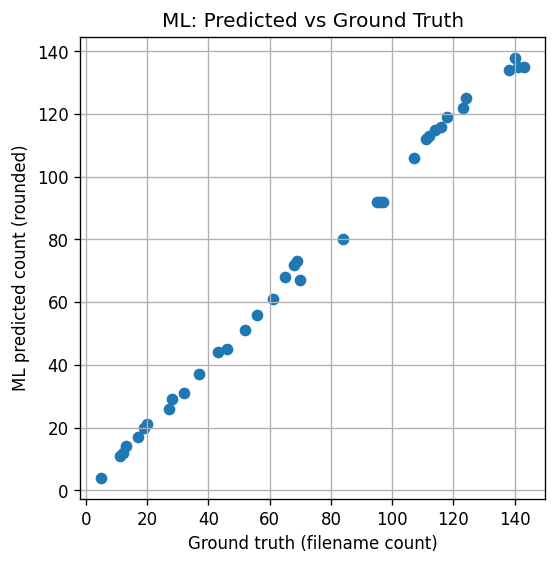

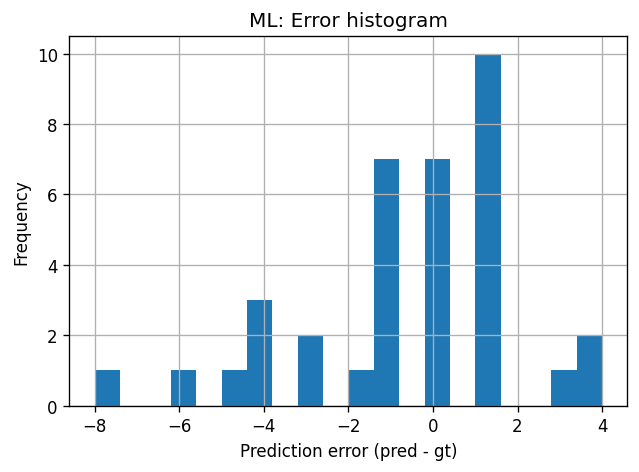

,feature,importance
1,std_gray,0.305822
7,cc_count_raw,0.278994
9,cc_area_median,0.275710
6,mask_frac,0.030084
4,edge_mean,0.026274
5,edge_std,0.022488
8,cc_area_mean,0.020474
2,mean_norm,0.014256
0,mean_gray,0.009852
11,wf1_pred,0.007201



ML full-dataset mean acc %: 97.76


,mean_gray,std_gray,mean_norm,std_norm,edge_mean,edge_std,mask_frac,cc_count_raw,cc_area_mean,cc_area_median,cc_area_std,wf1_pred,wf2_pred,gt,image,ml_pred_float,ml_pred,ml_abs_err,ml_acc_%
139,161.681696,52.586310,12.991270,21.532464,20.993542,34.653591,0.157279,152.0,1252.019737,278.0,2586.191534,8.0,2.0,143,143.jpg,135.2450,135,8,94.405594
137,180.297964,51.306763,14.824617,24.144705,22.994579,39.565075,0.164293,140.0,1419.964286,280.5,3970.338398,6.0,31.0,141,141.jpg,135.2725,135,6,95.744681
95,175.251621,44.479963,19.492261,28.136194,20.884859,42.980320,0.191874,51.0,4552.313725,2262.0,9526.989464,29.0,26.0,97,97.jpg,92.0650,92,5,94.845361
67,182.406240,39.334891,14.960631,23.958244,15.164783,35.198936,0.156523,44.0,4304.386364,2880.0,5721.000843,38.0,32.0,69,69.jpg,72.6400,73,4,94.202899
82,172.646998,39.802728,14.808335,22.031490,16.102865,34.290382,0.166783,56.0,3603.714286,1698.5,6847.620702,20.0,3.0,84,84.jpg,80.1300,80,4,95.238095
94,178.011574,44.290229,19.857664,28.784766,20.873297,43.176323,0.189987,53.0,4337.433962,2365.0,7216.971739,31.0,31.0,96,96.jpg,91.8575,92,4,95.833333
134,181.235351,50.875628,15.182793,24.414615,22.647888,39.650818,0.182129,131.0,1682.259542,193.0,8467.633296,14.0,13.0,138,138.jpg,133.6750,134,4,97.101449
66,182.108979,39.227100,15.280497,24.737977,14.947709,34.934937,0.153930,42.0,4434.642857,2778.5,8292.548634,39.0,18.0,68,68.jpg,72.1300,72,4,94.117647
96,205.759766,49.838150,7.246449,18.186276,14.636395,30.808031,0.075717,112.0,818.017857,360.5,1702.442573,0.0,57.0,98,98.jpg,101.6700,102,4,95.918367
68,181.618109,39.784063,15.807434,25.614568,15.243324,35.242580,0.158533,36.0,5328.472222,2972.0,7934.467634,38.0,12.0,70,70.jpg,67.4425,67,3,95.714286


In [26]:
# =========================
# 10) ML WORKFLOW (guarded)
# =========================
if not RUN_ML_WORKFLOW:
    print("ML workflow is OFF. Set RUN_ML_WORKFLOW = True to run it.")
else:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # -------------------------
    # Settings
    # -------------------------
    USE_WF_COUNTS_AS_FEATURES = True   # set False if you want "pure" image features only
    TEST_SIZE = 0.25
    RANDOM_STATE = 42

    # -------------------------
    # Helper: list numeric-named images
    # -------------------------
    def list_numeric_images(dataset_dir):
        exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
        files = []
        for f in os.listdir(dataset_dir):
            fl = f.lower()
            if fl.endswith(exts):
                base = os.path.splitext(f)[0]
                if re.fullmatch(r"\d+", base):
                    files.append(f)
        files.sort(key=lambda f: int(os.path.splitext(f)[0]))
        return [os.path.join(dataset_dir, f) for f in files]

    # -------------------------
    # Feature extraction (explainable DIP features)
    # -------------------------
    def extract_features(img_bgr):
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Illumination-normalised-ish: blur background
        bg = cv2.GaussianBlur(gray, (0,0), 15)
        norm = cv2.subtract(gray, bg)  # can be negative -> saturates at 0 in uint8
        norm = cv2.normalize(norm, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Otsu mask on norm (simple “seed region” proxy)
        _, bw = cv2.threshold(norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morph cleanup
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, k, iterations=1)
        bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, k, iterations=2)

        # Connected components
        n_cc, labels, stats, _ = cv2.connectedComponentsWithStats(bw, 8)
        areas = stats[1:, cv2.CC_STAT_AREA] if n_cc > 1 else np.array([], dtype=np.int32)

        # Intensity stats
        mean_g = float(np.mean(gray))
        std_g  = float(np.std(gray))
        mean_n = float(np.mean(norm))
        std_n  = float(np.std(norm))

        # Edge energy (polarity-invariant)
        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        mag = cv2.magnitude(gx, gy)
        edge_mean = float(np.mean(mag))
        edge_std  = float(np.std(mag))

        # Mask coverage
        mask_area = float(np.sum(bw > 0))
        mask_frac = float(mask_area / (bw.shape[0] * bw.shape[1]))

        # Component area summary (helps distinguish 30 vs 120 density)
        if areas.size:
            area_median = float(np.median(areas))
            area_mean   = float(np.mean(areas))
            area_std    = float(np.std(areas))
        else:
            area_median = area_mean = area_std = 0.0

        feats = {
            "mean_gray": mean_g,
            "std_gray": std_g,
            "mean_norm": mean_n,
            "std_norm": std_n,
            "edge_mean": edge_mean,
            "edge_std": edge_std,
            "mask_frac": mask_frac,
            "cc_count_raw": float(max(n_cc - 1, 0)),
            "cc_area_mean": area_mean,
            "cc_area_median": area_median,
            "cc_area_std": area_std,
        }

        # Optional: include classical pipeline predictions as features
        if USE_WF_COUNTS_AS_FEATURES:
            try:
                feats["wf1_pred"] = float(workflow1_count_v2(img_bgr, debug=False))
            except Exception:
                feats["wf1_pred"] = 0.0
            try:
                feats["wf2_pred"] = float(workflow2_count_lbp(img_bgr, debug=False))
            except Exception:
                feats["wf2_pred"] = 0.0

        return feats

    # -------------------------
    # Build dataset
    # -------------------------
    paths = list_numeric_images(DATASET_DIR)
    if len(paths) < 20:
        print("Warning: dataset looks small. ML will be unstable with very few images.")

    X_rows = []
    y = []
    names = []

    for p in paths:
        img = read_bgr_fast(p, max_dim=MAX_DIM)
        feats = extract_features(img)
        X_rows.append(feats)
        y.append(gt_from_filename(p))
        names.append(os.path.basename(p))

    df = pd.DataFrame(X_rows)
    df["gt"] = y
    df["image"] = names

    print("Feature table shape:", df.shape)
    display(df.head(5))

    # -------------------------
    # Train/test split
    # -------------------------
    feature_cols = [c for c in df.columns if c not in ("gt", "image")]
    X = df[feature_cols].values
    y = df["gt"].values

    X_train, X_test, y_train, y_test, name_train, name_test = train_test_split(
        X, y, df["image"].values, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    # -------------------------
    # Train model
    # -------------------------
    model = RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # -------------------------
    # Evaluate
    # -------------------------
    pred = model.predict(X_test)
    pred_round = np.clip(np.rint(pred), 0, None).astype(int)  # counts must be integers >= 0

    mae = mean_absolute_error(y_test, pred_round)
    rmse = mean_squared_error(y_test, pred_round) ** 0.5
    r2 = r2_score(y_test, pred)

    # Count-closeness accuracy %
    acc_pct = np.mean([100.0 * max(0.0, 1.0 - abs(p-g)/g) for p, g in zip(pred_round, y_test)])

    # Proxy precision/recall (count-based)
    def pr_from_counts(gt, pred):
        tp = min(int(pred), int(gt))
        fp = max(int(pred) - int(gt), 0)
        fn = max(int(gt) - int(pred), 0)
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        return prec, rec

    pr_list = [pr_from_counts(g, p) for g, p in zip(y_test, pred_round)]
    prec_mean = float(np.mean([x[0] for x in pr_list]))
    rec_mean  = float(np.mean([x[1] for x in pr_list]))

    print("\nML RESULTS (RandomForestRegressor)")
    print("MAE:", round(mae, 3))
    print("RMSE:", round(rmse, 3))
    print("R2 (on non-rounded preds):", round(r2, 3))
    print("Mean count-closeness accuracy %:", round(acc_pct, 2))
    print("Proxy Precision mean:", round(prec_mean, 3))
    print("Proxy Recall mean:", round(rec_mean, 3))

    # Detailed table for screenshots
    df_eval = pd.DataFrame({
        "image": name_test,
        "gt": y_test,
        "pred_float": pred,
        "pred_round": pred_round,
        "abs_err": np.abs(pred_round - y_test),
    }).sort_values("abs_err", ascending=False)
    display(df_eval.head(15))

    # -------------------------
    # Plots (for report screenshots)
    # -------------------------
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, pred_round)
    plt.xlabel("Ground truth (filename count)")
    plt.ylabel("ML predicted count (rounded)")
    plt.title("ML: Predicted vs Ground Truth")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(pred_round - y_test, bins=20)
    plt.xlabel("Prediction error (pred - gt)")
    plt.ylabel("Frequency")
    plt.title("ML: Error histogram")
    plt.grid(True)
    plt.show()

    # -------------------------
    # Optional: feature importance (nice for report)
    # -------------------------
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)
    display(fi.head(15))

    # -------------------------
    # Optional: run ML on full dataset and compare to WF1/WF2
    # -------------------------
    df["ml_pred_float"] = model.predict(df[feature_cols].values)
    df["ml_pred"] = np.clip(np.rint(df["ml_pred_float"]), 0, None).astype(int)
    df["ml_abs_err"] = np.abs(df["ml_pred"] - df["gt"])
    df["ml_acc_%"] = [100.0 * max(0.0, 1.0 - abs(p-g)/g) for p, g in zip(df["ml_pred"], df["gt"])]

    print("\nML full-dataset mean acc %:", round(float(np.mean(df['ml_acc_%'])), 2))
    display(df.sort_values("ml_abs_err", ascending=False).head(10))


In [27]:
import os, re
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_row(images, titles, suptitle="", figsize=(22, 4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (img, t) in enumerate(zip(images, titles), 1):
        ax = plt.subplot(1, n, i)
        if img.ndim == 2:
            ax.imshow(img, cmap="gray")
        else:
            # assume BGR coming from cv2; convert for display
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(t, fontsize=10)
        ax.axis("off")
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

def gt_from_filename(path: str) -> int:
    base = os.path.splitext(os.path.basename(path))[0]
    if not re.fullmatch(r"\d+", base):
        raise ValueError(f"Filename not pure digits: {path}")
    return int(base)

def read_bgr_fast(path: str, max_dim=1100):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    h, w = img.shape[:2]
    m = max(h, w)
    if m > max_dim:
        s = max_dim / m
        img = cv2.resize(img, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
    return img

# >>> IMPORTANT: set this correctly <<<
DATASET_DIR = r"./seeds"   # change if needed


In [28]:
print("CWD:", os.getcwd())
print("DATASET_DIR exists:", os.path.exists(DATASET_DIR))
print("Example file exists:", os.path.exists(os.path.join(DATASET_DIR, "5.jpg")))


CWD: c:\Users\Thegeek\Downloads\seeds
DATASET_DIR exists: True
Example file exists: True


Image: 30.jpg | GT: 30 | shape: (1100, 1100, 3)


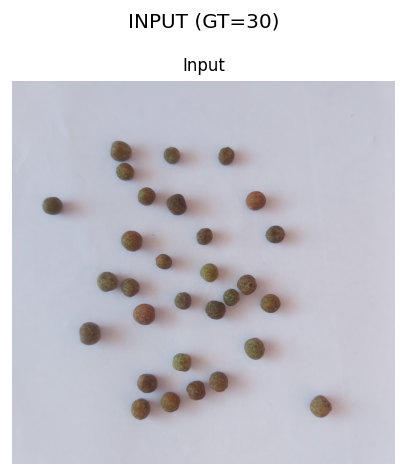

In [29]:
t = 30  # change to 5 / 30 / 70 / 90 / 120 for screenshots
p = os.path.join(DATASET_DIR, f"{t}.jpg")
img = read_bgr_fast(p, max_dim=1100)
gt = gt_from_filename(p)
print("Image:", os.path.basename(p), "| GT:", gt, "| shape:", img.shape)
show_row([img], ["Input"], suptitle=f"INPUT (GT={gt})", figsize=(6,4))


FAILED M1 (Gray+Otsu+CC): pred=20, gt=30, abs_err=10
Why it failed: shadows/uneven illumination connect neighbouring seeds -> under-count (merged blobs).


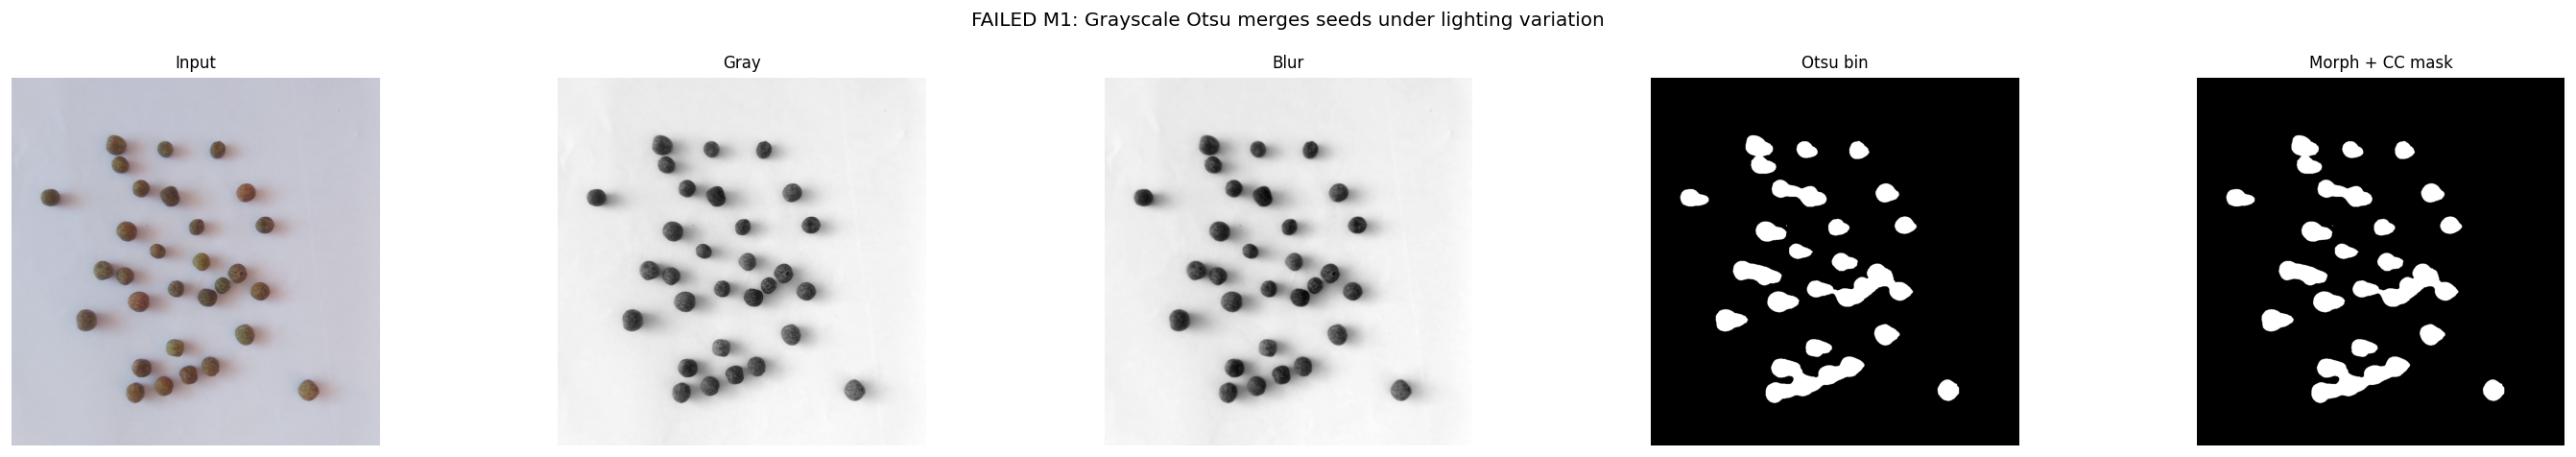

In [30]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

# Otsu
_, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# light morphology
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
bw_m = cv2.morphologyEx(bw, cv2.MORPH_OPEN, k, iterations=1)
bw_m = cv2.morphologyEx(bw_m, cv2.MORPH_CLOSE, k, iterations=1)

# count by CC
num, labels = cv2.connectedComponents(bw_m)
pred = num - 1

print(f"FAILED M1 (Gray+Otsu+CC): pred={pred}, gt={gt}, abs_err={abs(pred-gt)}")
print("Why it failed: shadows/uneven illumination connect neighbouring seeds -> under-count (merged blobs).")

show_row(
    [img, gray, blur, bw, bw_m],
    ["Input", "Gray", "Blur", "Otsu bin", "Morph + CC mask"],
    suptitle="FAILED M1: Grayscale Otsu merges seeds under lighting variation",
    figsize=(24,4)
)


FAILED M2 (Too much blur): pred=20, gt=30, abs_err=10
Why it failed: blur closes the small gaps between touching seeds -> multiple seeds become one region.


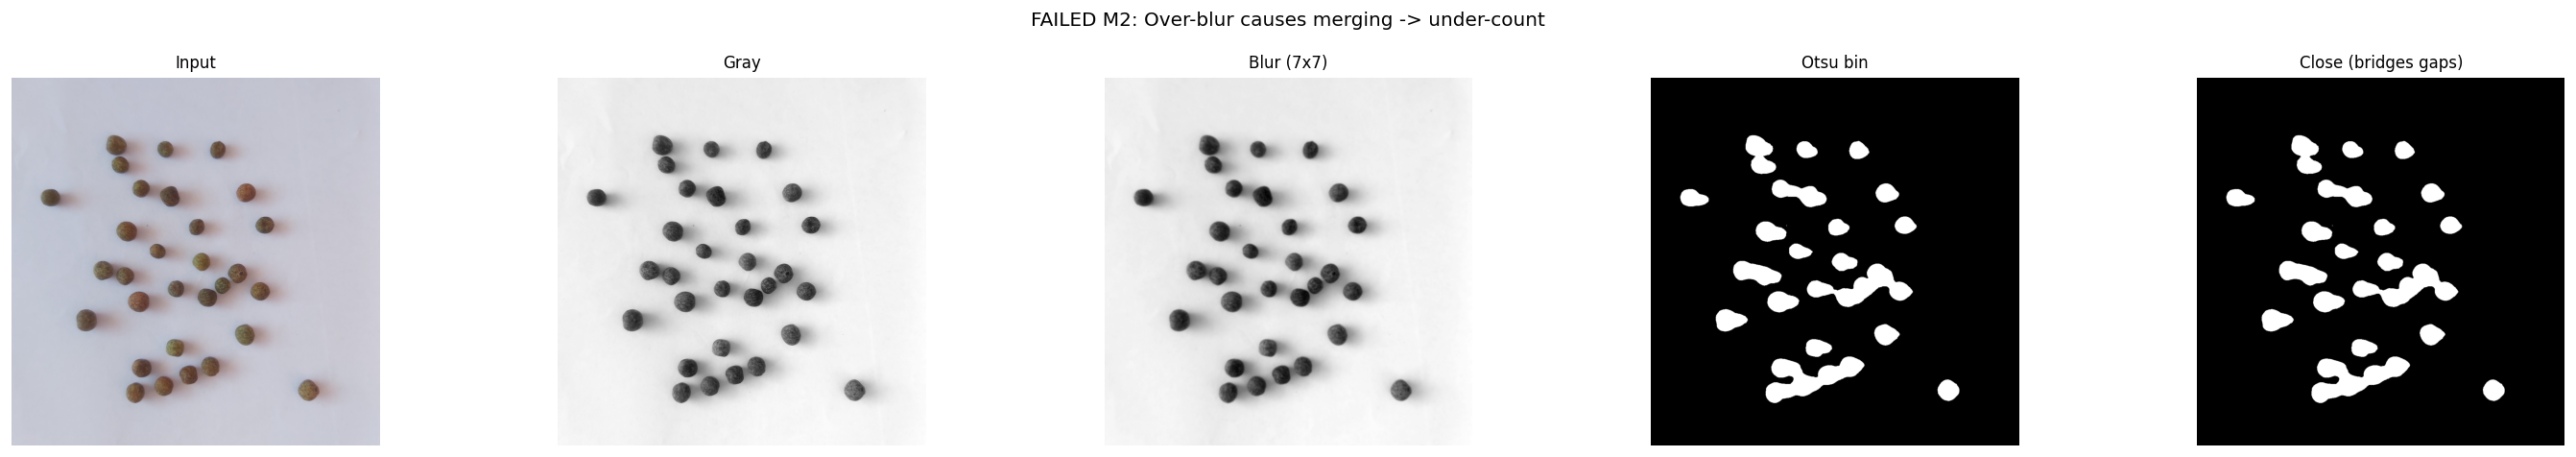

In [31]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur7 = cv2.GaussianBlur(gray, (7,7), 0)  # intentionally heavy
_, bw7 = cv2.threshold(blur7, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
bw7_m = cv2.morphologyEx(bw7, cv2.MORPH_CLOSE, k, iterations=2)

pred7 = cv2.connectedComponents(bw7_m)[0] - 1

print(f"FAILED M2 (Too much blur): pred={pred7}, gt={gt}, abs_err={abs(pred7-gt)}")
print("Why it failed: blur closes the small gaps between touching seeds -> multiple seeds become one region.")

show_row(
    [img, gray, blur7, bw7, bw7_m],
    ["Input", "Gray", "Blur (7x7)", "Otsu bin", "Close (bridges gaps)"],
    suptitle="FAILED M2: Over-blur causes merging -> under-count",
    figsize=(24,4)
)


In [32]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

dist = cv2.distanceTransform(bw, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.4*dist.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

# INTENTIONAL BUG DEMO:
# resize markers so it doesn't match the image size -> watershed assertion fails
markers_bad = cv2.resize(markers.astype(np.int32), (markers.shape[1]//2, markers.shape[0]//2))

print("This cell intentionally demonstrates the watershed size-mismatch failure you hit.")
print("Why it failed: watershed requires markers and image to have EXACT same HxW.")

try:
    _ = cv2.watershed(img.copy(), markers_bad)
except Exception as e:
    print("Expected error:", e)


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4026: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


FAILED M4 (LBP mask CC naive): pred=306, gt=30
Why it failed: LBP responds to micro texture everywhere -> many small components -> huge over-count.


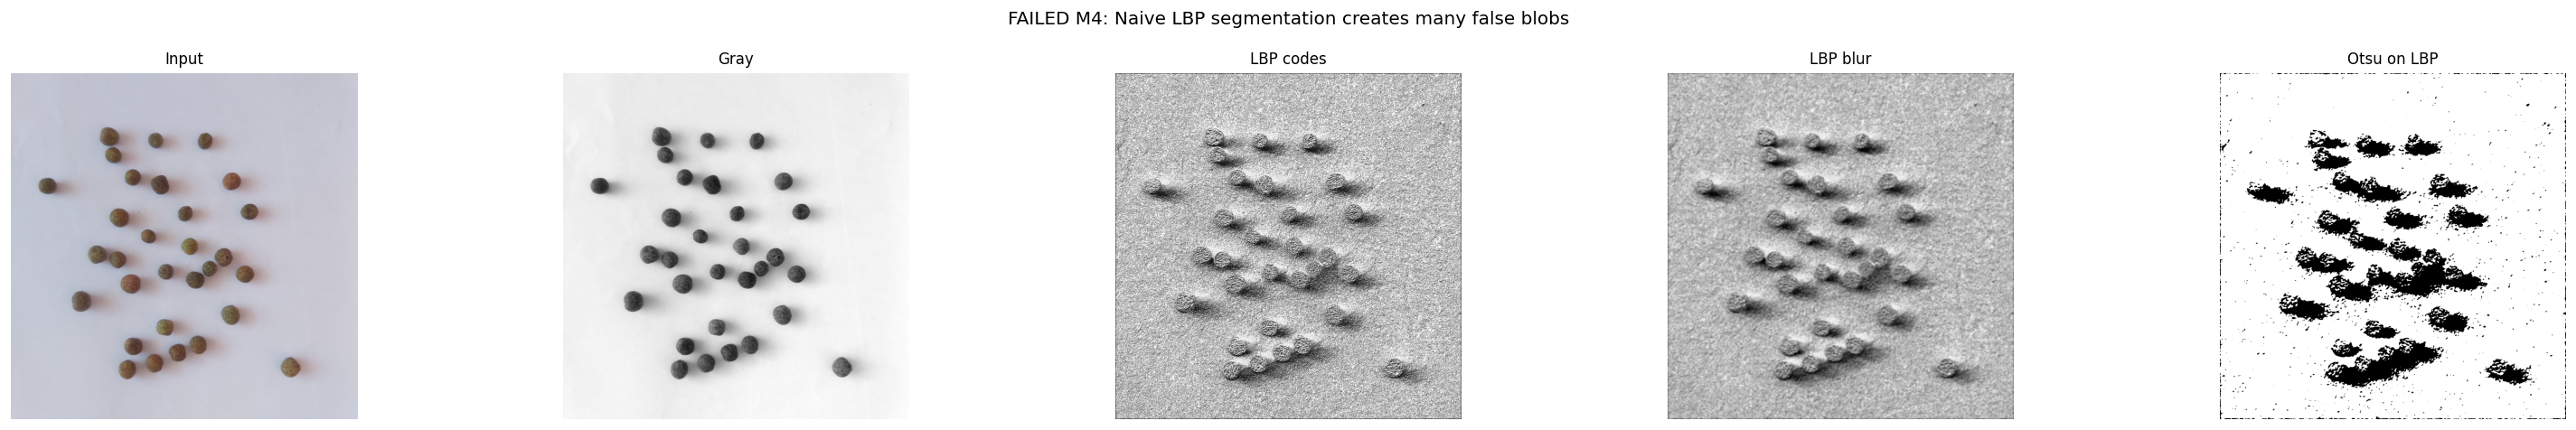

In [ ]:
def lbp_8u1(gray_u8):
    g = gray_u8.astype(np.uint8)
    c = g[1:-1, 1:-1]
    codes = np.zeros_like(c, dtype=np.uint8)

    n0 = g[0:-2, 0:-2]
    n1 = g[0:-2, 1:-1]
    n2 = g[0:-2, 2:  ]
    n3 = g[1:-1, 2:  ]
    n4 = g[2:  , 2:  ]
    n5 = g[2:  , 1:-1]
    n6 = g[2:  , 0:-2]
    n7 = g[1:-1, 0:-2]

    codes |= ((n0 >= c) << 7).astype(np.uint8)
    codes |= ((n1 >= c) << 6).astype(np.uint8)
    codes |= ((n2 >= c) << 5).astype(np.uint8)
    codes |= ((n3 >= c) << 4).astype(np.uint8)
    codes |= ((n4 >= c) << 3).astype(np.uint8)
    codes |= ((n5 >= c) << 2).astype(np.uint8)
    codes |= ((n6 >= c) << 1).astype(np.uint8)
    codes |= ((n7 >= c) << 0).astype(np.uint8)

    out = np.zeros_like(g, dtype=np.uint8)
    out[1:-1, 1:-1] = codes
    return out

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp = lbp_8u1(gray)
lbp_blur = cv2.GaussianBlur(lbp, (9,9), 0)
_, bw = cv2.threshold(lbp_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# naive counting of CC on this mask
num, _ = cv2.connectedComponents(bw)
pred = num - 1

print(f"FAILED M4 (LBP mask CC naive): pred={pred}, gt={gt}")
print("Why it failed: LBP responds to micro texture everywhere -> many small components -> huge over-count.")

show_row(
    [img, gray, lbp, lbp_blur, bw],
    ["Input", "Gray", "LBP codes", "LBP blur", "Otsu on LBP"],
    suptitle="FAILED M4: Naive LBP segmentation creates many false blobs",
    figsize=(26,4)
)


In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if hasattr(cv2, "SIFT_create"):
    det = cv2.SIFT_create()
    method = "SIFT"
else:
    det = cv2.ORB_create(nfeatures=2000)
    method = "ORB"

kps, des = det.detectAndCompute(gray, None)
kp_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(f"FAILED M5 ({method} keypoints): num_keypoints={len(kps)} vs gt={gt}")
print("Why it failed: keypoint count depends on texture/contrast, not object count. One seed can generate many or zero keypoints.")

show_row(
    [img, kp_img],
    ["Input", f"{method} keypoints overlay"],
    suptitle="FAILED M5: Keypoint count is not a seed count",
    figsize=(12,4)
)


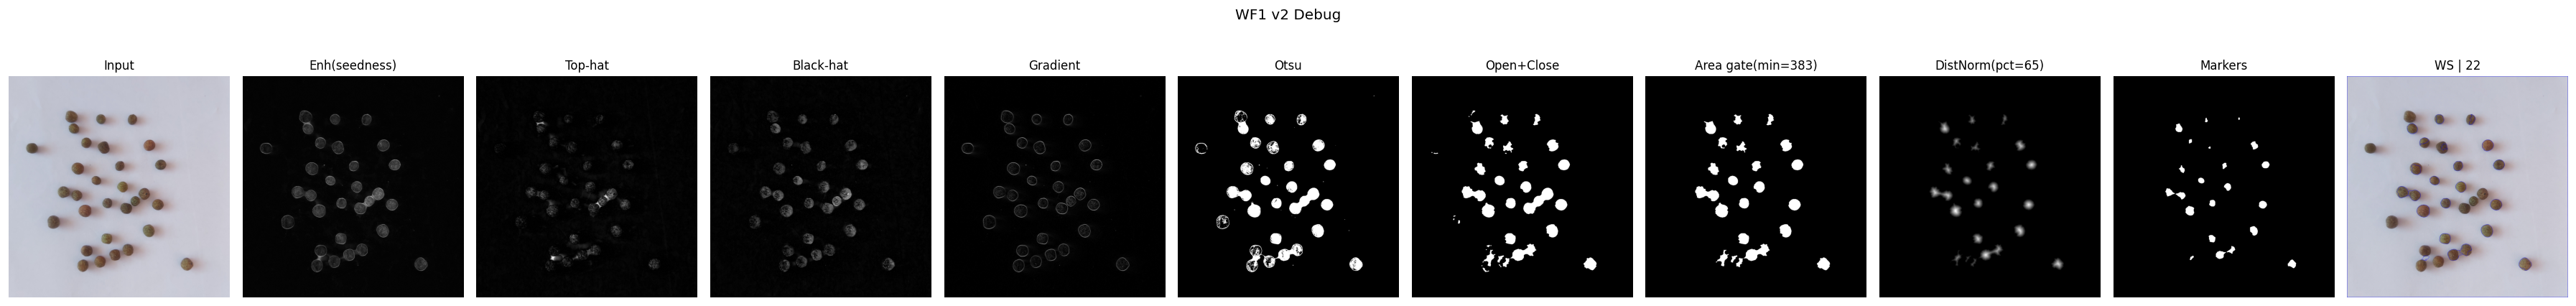

NameError: name 'workflow2_count_v2' is not defined

In [ ]:
# Change these names to match your notebook
# pred1 = workflow1_count_v2(img, debug=True)
# pred2 = workflow2_count_v2(img, debug=True)

pred1 = workflow1_count_v2(img, debug=True)
pred2 = workflow2_count_v2(img, debug=True)

print("FINAL COMPARISON")
print(f"WF1 final: pred={pred1}, gt={gt}, abs_err={abs(int(pred1)-gt)}")
print(f"WF2 final: pred={pred2}, gt={gt}, abs_err={abs(int(pred2)-gt)}")
print("Why final worked: illumination correction + morphology gives cleaner blobs, watershed/controlled splitting handles touching seeds, and WF2 uses LBP as guidance rather than counting texture dots.")


In [ ]:
def count_pr_proxy(gt, pred):
    # proxy: treat min(gt,pred) as "matched" counts
    tp = min(int(gt), int(pred))
    fp = max(int(pred) - int(gt), 0)
    fn = max(int(gt) - int(pred), 0)
    prec = tp / (tp + fp) if (tp + fp) else 1.0
    rec  = tp / (tp + fn) if (tp + fn) else 1.0
    return prec, rec

def pr_auc(points):
    # points: list of (recall, precision), sorted by recall
    pts = sorted(points, key=lambda x: x[0])
    auc = 0.0
    for (r1,p1),(r2,p2) in zip(pts[:-1], pts[1:]):
        auc += (r2-r1) * (p1+p2) / 2.0
    return auc, pts

# Example: PR curve for WF1 by sweeping one parameter (fg_ratio)
# You must adapt this to match your WF1 function signature.
ratios = np.linspace(0.25, 0.60, 10)
pr_points = []

for r in ratios:
    pred = workflow1_count_v2(img, fg_ratio=float(r), debug=False)  # change if needed
    prec, rec = count_pr_proxy(gt, pred)
    pr_points.append((rec, prec))

auc, pts = pr_auc(pr_points)
print("PR points (proxy):", pts)
print("PR-AUC (proxy):", auc)

# plot
rs = [r for r,_ in pts]
ps = [p for _,p in pts]
plt.figure(figsize=(5,4))
plt.plot(rs, ps, marker="o")
plt.xlabel("Recall (proxy)")
plt.ylabel("Precision (proxy)")
plt.title("PR curve (count-based proxy)")
plt.grid(True)
plt.show()

print("Note for report: This PR/AUC is a count-based proxy because we do not have per-seed ground-truth locations.")


TypeError: workflow1_count_v2() got an unexpected keyword argument 'fg_ratio'